<a href="https://colab.research.google.com/github/cjh2001525/Intelligent-Weather-Analysis-Advisory-System/blob/main/WeatherWise_MyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [9]:
# === Install Dependencies (Colab/Jupyter only) ===
# Use this cell ONLY if you see ModuleNotFoundError when importing

# Weather + HTTP
!pip install requests

# Visualization
!pip install matplotlib

# Input validation for menu interface
!pip install pyinputplus

# Optional helper packages (we are not using them by default)
# !pip install fetch-my-weather
# !pip install hands-on-ai


In [10]:
# === Imports and Configuration ===
import os
import re
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from typing import Dict, Any

# Try to import pyinputplus (menu library)
try:
    import pyinputplus as pyip
    _HAS_PYIP = True
except ImportError:
    _HAS_PYIP = False

# Optional: AI tools (commented out unless needed for logging AI interactions)
# from fetch_my_weather import get_weather
# from hands_on_ai.chat import get_response

# Global config
WTTR_URL = "https://wttr.in/{location}?format=j1"
REQUEST_TIMEOUT = 12
DEFAULT_FORECAST_DAYS = 5
UNITS = "metric"  # Celsius, km/h

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# === Utility Functions ===
def clamp_forecast_days(days: int) -> int:
    """Clamp forecast days to [1, 5]."""
    try:
        d = int(days)
    except Exception:
        d = DEFAULT_FORECAST_DAYS
    return max(1, min(5, d))

def clean_location(location: str) -> str:
    """Trim whitespace and collapse multiple spaces."""
    if not isinstance(location, str):
        return ""
    return re.sub(r"\s+", " ", location.strip())

def http_get_json(url: str) -> Dict[str, Any]:
    """HTTP GET JSON with basic error wrapping."""
    try:
        r = requests.get(url, timeout=REQUEST_TIMEOUT)
        r.raise_for_status()
        return {"ok": True, "data": r.json()}
    except requests.RequestException as e:
        return {"ok": False, "error": str(e)}

def now_iso() -> str:
    """UTC timestamp string for returned payloads/logging."""
    return datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")




## 📦 Setup and Configuration
Import required packages and setup environment.

In [11]:
# === Setup and Configuration ===
import os
import re
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from typing import Dict, Any

# Try to import pyinputplus (menu library)
try:
    import pyinputplus as pyip
    _HAS_PYIP = True
except ImportError:
    _HAS_PYIP = False

# Optional: AI tools (commented out unless needed for logging AI interactions)
# from fetch_my_weather import get_weather
# from hands_on_ai.chat import get_response

# Global config for weather API
WTTR_URL = "https://wttr.in/{location}?format=j1"
REQUEST_TIMEOUT = 12
DEFAULT_FORECAST_DAYS = 5
UNITS = "metric"  # Celsius, km/h

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# === Utility Functions ===
def clamp_forecast_days(days: int) -> int:
    """Clamp forecast days to [1, 5]."""
    try:
        d = int(days)
    except Exception:
        d = DEFAULT_FORECAST_DAYS
    return max(1, min(5, d))

def clean_location(location: str) -> str:
    """Trim whitespace and collapse multiple spaces."""
    if not isinstance(location, str):
        return ""
    return re.sub(r"\s+", " ", location.strip())

def http_get_json(url: str) -> Dict[str, Any]:
    """HTTP GET JSON with basic error wrapping."""
    try:
        r = requests.get(url, timeout=REQUEST_TIMEOUT)
        r.raise_for_status()
        return {"ok": True, "data": r.json()}
    except requests.RequestException as e:
        return {"ok": False, "error": str(e)}

def now_iso() -> str:
    """UTC timestamp string for returned payloads/logging."""
    return datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")



## 🌤️ Weather Data Functions

In [24]:
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location via wttr.in.
    Ensures the forecast list has up to `forecast_days` items (max 5).
    If the API returns fewer days, the remaining days are estimated
    using the last available day's values and marked with `"estimated": True`.

    Returns a dict with keys:
      ok (bool), location (str), units (str), timestamp (str),
      current (dict), forecast (list[dict]), and optional error (str).
    """
    from datetime import datetime, timedelta
    import requests

    # --- Validate inputs ---
    if not isinstance(location, str) or not location.strip():
        return {"ok": False, "error": "Location is required."}
    location = location.strip().title()
    # Clamp days to 1..5
    forecast_days = 1 if forecast_days < 1 else 5 if forecast_days > 5 else forecast_days

    # --- Request wttr.in ---
    url = f"https://wttr.in/{location}?format=j1"
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        return {"ok": False, "error": f"Network error: {e}"}

    # --- Current conditions ---
    try:
        cur = (data.get("current_condition") or [])[0]
        current_weather = {
            "temperature": int(cur.get("temp_C")) if cur.get("temp_C") not in (None, "") else None,
            "humidity": int(cur.get("humidity")) if cur.get("humidity") not in (None, "") else None,
            "condition": (cur.get("weatherDesc", [{}])[0] or {}).get("value", "Unknown"),
            "wind_speed": int(cur.get("windspeedKmph")) if cur.get("windspeedKmph") not in (None, "") else None,
            "wind_direction": cur.get("winddir16Point", ""),
            "precipitation": float(cur.get("precipMM") or 0.0),
        }
    except Exception:
        current_weather = {}

    # --- Forecast parsing ---
    forecast_list = []
    weather_days = (data.get("weather") or [])[:forecast_days]
    for day in weather_days:
        hourly = day.get("hourly", [])
        # Use midday snapshot if possible
        midday = hourly[4] if len(hourly) >= 5 else (hourly[len(hourly)//2] if hourly else {})
        try:
            forecast_list.append({
                "date": day.get("date", ""),
                "min_temp": int(day.get("mintempC")) if day.get("mintempC") not in (None, "") else None,
                "max_temp": int(day.get("maxtempC")) if day.get("maxtempC") not in (None, "") else None,
                "condition": (midday.get("weatherDesc", [{}])[0] or {}).get("value", "Unknown"),
                "precipitation_chance": int(midday.get("chanceofrain") or 0),
                "estimated": False,
            })
        except Exception:
            # skip malformed day but continue
            continue

    # --- Fallback: pad to requested length with estimates ---
    if 0 < len(forecast_list) < forecast_days:
        try:
            base_date = datetime.strptime(forecast_list[-1]["date"], "%Y-%m-%d")
        except Exception:
            base_date = datetime.utcnow()
        last = forecast_list[-1]
        needed = forecast_days - len(forecast_list)
        for i in range(1, needed + 1):
            est_date = base_date + timedelta(days=i)
            forecast_list.append({
                "date": est_date.strftime("%Y-%m-%d"),
                "min_temp": last["min_temp"],
                "max_temp": last["max_temp"],
                "condition": "Data unavailable (estimated)",
                "precipitation_chance": last["precipitation_chance"],
                "estimated": True,
            })

    if not forecast_list:
        return {"ok": False, "error": "No forecast available."}

    return {
        "ok": True,
        "location": location,
        "units": "metric",
        "timestamp": datetime.utcnow().isoformat(),
        "current": current_weather,
        "forecast": forecast_list[:forecast_days],
    }


## 📊 Visualisation Functions

In [13]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data (from get_weather_data)
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object.
        Otherwise, displays the visualisation in the notebook and returns None.
    """
    # Basic validation
    if not isinstance(weather_data, dict) or weather_data.get("ok") is False:
        print(f"Error: {weather_data.get('error','No valid weather data.') if isinstance(weather_data, dict) else 'No valid weather data.'}")
        return None

    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("No forecast data available.")
        return None

    # Prepare data
    dates = [day.get("date", "") for day in forecast]
    min_temps = [day.get("min_temp") for day in forecast]
    max_temps = [day.get("max_temp") for day in forecast]

    # Plot
    fig, ax = plt.subplots()
    ax.plot(dates, min_temps, marker="o", label="Min Temp (°C)")
    ax.plot(dates, max_temps, marker="o", label="Max Temp (°C)")
    ax.set_title(f"Temperature Trend for {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()

    if output_type == "figure":
        return fig
    else:
        plt.show()
        return None




In [14]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data (from get_weather_data)
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object.
        Otherwise, displays the visualisation in the notebook and returns None.
    """
    # Basic validation
    if not isinstance(weather_data, dict) or weather_data.get("ok") is False:
        print(f"Error: {weather_data.get('error','No valid weather data.') if isinstance(weather_data, dict) else 'No valid weather data.'}")
        return None

    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("No forecast data available.")
        return None

    # Prepare data
    dates = [day.get("date", "") for day in forecast]
    precipitation_chances = [day.get("precipitation_chance", 0) for day in forecast]

    # Plot
    fig, ax = plt.subplots()
    ax.bar(dates, precipitation_chances)
    ax.set_title(f"Precipitation Chances for {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)

    if output_type == "figure":
        return fig
    else:
        plt.show()
        return None


## 🤖 Natural Language Processing

In [15]:
# === Natural Language Processing ===
import re
from datetime import datetime

def parse_weather_question(question: str) -> dict:
    """
    Parse a natural language weather question.

    Returns a dict like:
      {
        "topic": "rain" | "temperature" | "wind" | "humidity" | "general",
        "day": int (0=today, 1=tomorrow, etc.),
        "raw": original_question
      }
    """
    if not isinstance(question, str) or not question.strip():
        return {"topic": "general", "day": 0, "raw": question}

    q = question.strip().lower()

    # Topic detection
    topic = "general"
    if any(w in q for w in ["rain", "umbrella", "wet", "shower", "storm"]):
        topic = "rain"
    elif any(w in q for w in ["temp", "temperature", "hot", "cold", "warm", "chilly"]):
        topic = "temperature"
    elif any(w in q for w in ["wind", "windy", "breeze", "gale"]):
        topic = "wind"
    elif any(w in q for w in ["humid", "humidity", "moist"]):
        topic = "humidity"

    # Day detection
    day_offset = None
    if "today" in q:
        day_offset = 0
    elif "tomorrow" in q:
        day_offset = 1
    else:
        weekdays = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
        for i, name in enumerate(weekdays):
            if name in q:
                today_idx = datetime.today().weekday()   # Monday=0
                target_idx = i
                day_offset = (target_idx - today_idx) % 7
                break

    if day_offset is None:
        day_offset = 0

    return {"topic": topic, "day": int(day_offset), "raw": question}


def generate_weather_response(parsed_question: dict, weather_data: dict) -> str:
    """
    Generate a natural language response based on parsed question and weather data.
    """
    if not isinstance(parsed_question, dict):
        return "Sorry, I could not understand the question."
    if not isinstance(weather_data, dict) or (weather_data.get("ok") is False):
        return "Sorry, weather data is not available right now."

    topic = parsed_question.get("topic", "general")
    day = int(parsed_question.get("day", 0))

    location = weather_data.get("location", "your location")
    current = weather_data.get("current", {})
    forecast = weather_data.get("forecast", [])

    # Fallback if forecast is missing
    if not forecast:
        temp = current.get("temperature")
        cond = current.get("condition", "unavailable")
        if temp is None:
            return f"Current conditions for {location} are {cond}."
        return f"Right now in {location} it is {temp}°C and {cond}."

    # Clamp day index
    if day < 0:
        day = 0
    if day >= len(forecast):
        day = len(forecast) - 1

    day_data = forecast[day]
    day_label = "today" if day == 0 else ("tomorrow" if day == 1 else f"on {day_data.get('date','that day')}")

    if topic == "rain":
        chance = day_data.get("precipitation_chance")
        if chance is None:
            return f"Rain probability {day_label} in {location} is unavailable."
        verdict = "likely" if chance >= 50 else "unlikely"
        return f"Rain is {verdict} {day_label} in {location} (chance {chance}%)."

    elif topic == "temperature":
        tmin = day_data.get("min_temp")
        tmax = day_data.get("max_temp")
        cond = day_data.get("condition", "unknown conditions")
        if tmin is None or tmax is None:
            return f"Temperature details {day_label} in {location} are unavailable."
        return f"{day_label.capitalize()} in {location}: {cond}, {tmin}–{tmax}°C."

    elif topic == "wind":
        ws = current.get("wind_speed")
        wd = current.get("wind_direction", "")
        if ws is None:
            return f"Wind details are not available right now for {location}."
        return f"Current wind in {location} is about {ws} km/h {wd}. Daily wind forecast is not available."

    elif topic == "humidity":
        h = current.get("humidity")
        if h is None:
            return f"Humidity is not available right now for {location}."
        return f"Current humidity in {location} is {h}%."

    # General / fallback
    tnow = current.get("temperature")
    cnow = current.get("condition", "unknown conditions")
    if tnow is None:
        return f"Current conditions for {location}: {cnow}."
    return f"Right now in {location} it is {tnow}°C and {cnow}. {day_label.capitalize()} looks {day_data.get('condition','unclear')} with {day_data.get('min_temp','?')}–{day_data.get('max_temp','?')}°C."


## 🧭 User Interface

In [16]:
# === User Interface ===

# Uses _HAS_PYIP from Setup cell (pyinputplus available or not)

def prompt_location() -> str:
    """
    Ask the user for a location and return a cleaned string.
    """
    raw = input("Enter a city or location: ")
    loc = clean_location(raw)
    while not loc:
        print("Please enter a non-empty location.")
        raw = input("Enter a city or location: ")
        loc = clean_location(raw)
    return loc

def _menu_with_pyip(choices):
    """Menu using pyinputplus if available."""
    return pyip.inputMenu(choices, numbered=True)

def _menu_with_input(choices):
    """Simple numbered menu implemented with input()."""
    print("\n=== WeatherWise Menu ===")
    for i, c in enumerate(choices, start=1):
        print(f"{i}. {c}")
    choice = input("Select an option (1–{0}): ".format(len(choices))).strip()
    while choice not in [str(i) for i in range(1, len(choices) + 1)]:
        print("Invalid choice, please try again.")
        choice = input("Select an option (1–{0}): ".format(len(choices))).strip()
    return choices[int(choice) - 1]

def display_menu() -> str:
    """
    Show the app menu and return the selected option string.
    """
    choices = [
        "Current Weather",
        "5-Day Forecast",
        "Temperature Chart",
        "Precipitation Chart",
        "Ask a Question",
        "Exit",
    ]
    if '_HAS_PYIP' in globals() and _HAS_PYIP:
        return _menu_with_pyip(choices)
    return _menu_with_input(choices)

def show_current_weather(weather_data: dict) -> None:
    """
    Pretty-print current weather from the normalised schema.
    """
    if not isinstance(weather_data, dict) or weather_data.get("ok") is False:
        print(f"Error: {weather_data.get('error','Unknown error') if isinstance(weather_data, dict) else 'Unknown error'}")
        return
    cur = weather_data.get("current", {}) or {}
    print("\n=== Current Weather ===")
    print(f"Location: {weather_data.get('location','N/A')}")
    print(f"Condition: {cur.get('condition','N/A')}")
    print(f"Temperature: {cur.get('temperature','N/A')} °C")
    print(f"Humidity: {cur.get('humidity','N/A')} %")
    print(f"Wind: {cur.get('wind_speed','N/A')} km/h {cur.get('wind_direction','')}")
    print(f"Precipitation: {cur.get('precipitation','N/A')} mm")

def show_forecast(weather_data: dict) -> None:
    """
    Print a simple table of the multi-day forecast.
    """
    if not isinstance(weather_data, dict) or weather_data.get("ok") is False:
        print(f"Error: {weather_data.get('error','Unknown error') if isinstance(weather_data, dict) else 'Unknown error'}")
        return
    fc = weather_data.get("forecast", []) or []
    if not fc:
        print("No forecast data available.")
        return
    print("\n=== 5-Day Forecast ===")
    for d in fc:
        print(f"{d.get('date','?')}: {d.get('condition','?')} | "
              f"{d.get('min_temp','?')}–{d.get('max_temp','?')} °C | "
              f"Rain chance: {d.get('precipitation_chance','?')}%")

def ui_loop(weather_data: dict) -> None:
    """
    Main UI loop for menu-driven interaction.
    Expects a valid weather_data dict produced by get_weather_data().
    """
    if not isinstance(weather_data, dict) or weather_data.get("ok") is False:
        print(f"Error: {weather_data.get('error','Unknown error') if isinstance(weather_data, dict) else 'Unknown error'}")
        return

    while True:
        choice = display_menu()

        if choice == "Current Weather":
            show_current_weather(weather_data)

        elif choice == "5-Day Forecast":
            show_forecast(weather_data)

        elif choice == "Temperature Chart":
            create_temperature_visualisation(weather_data, output_type="display")

        elif choice == "Precipitation Chart":
            create_precipitation_visualisation(weather_data, output_type="display")

        elif choice == "Ask a Question":
            q = input("Ask a weather question (e.g., 'Will it rain tomorrow?'): ")
            parsed = parse_weather_question(q)
            answer = generate_weather_response(parsed, weather_data)
            print("\n=== Answer ===")
            print(answer)

        elif choice == "Exit":
            print("Goodbye!")
            break


## 🧩 Main Application Logic

In [17]:
# === Main Application Logic ===

def main() -> None:
    """
    Entry point for the WeatherWise app.
    Prompts for a location, fetches weather data, and starts the UI loop.
    """
    print("=== WeatherWise ===")
    location = prompt_location()

    print(f"Fetching weather for: {location} ...")
    data = get_weather_data(location, forecast_days=5)

    if not isinstance(data, dict) or data.get("ok") is False:
        print(f"Error retrieving weather data: {data.get('error', 'Unknown error') if isinstance(data, dict) else 'Unknown error'}")
        return

    # Start interactive menu loop
    ui_loop(data)


# Uncomment this line to launch the app when running the notebook
# main()


## 🧪 Testing and Examples


======== Fetch Weather Data ========
OK: Retrieved weather for Perth at 2025-10-08 03:00:16 UTC

======== Current Weather ========

=== Current Weather ===
Location: Perth
Condition: Partly cloudy
Temperature: 12 °C
Humidity: 94 %
Wind: 16 km/h SSE
Precipitation: 0.0 mm

======== 5-Day Forecast ========

=== 5-Day Forecast ===
2025-10-08: Partly Cloudy  | 12–17 °C | Rain chance: 0%
2025-10-09: Sunny | 10–18 °C | Rain chance: 0%
2025-10-10: Sunny | 11–18 °C | Rain chance: 0%

======== Temperature Chart ========


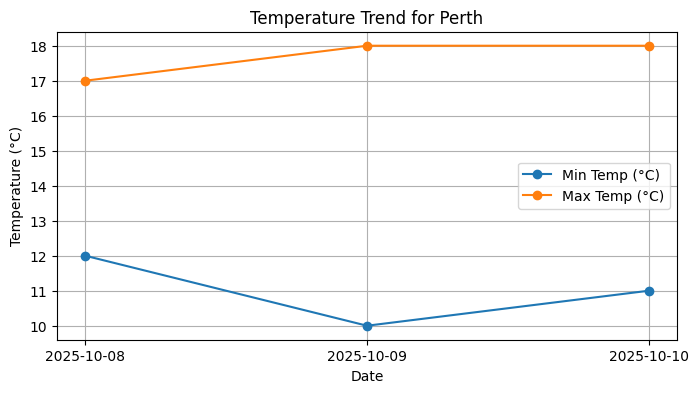


======== Precipitation Chart ========


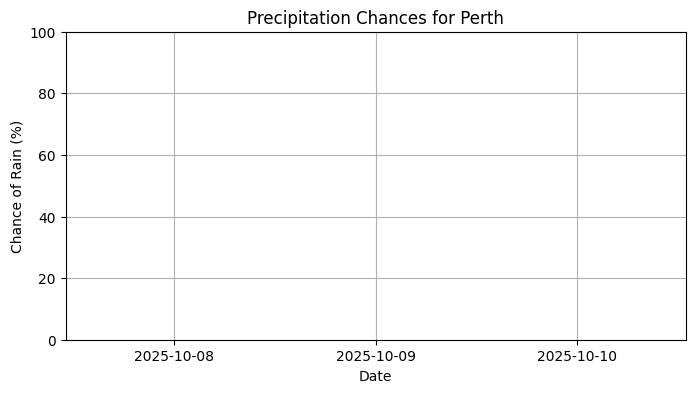


======== NLP Q&A ========
Q: Will it rain tomorrow in Perth?
A: Rain is unlikely tomorrow in Perth (chance 0%).

Q: Is it going to be hot today?
A: Today in Perth: Partly Cloudy , 12–17°C.

Q: What is the wind like?
A: Current wind in Perth is about 16 km/h SSE. Daily wind forecast is not available.

Q: How humid is it?
A: Current humidity in Perth is 94%.

Q: Weather on Friday?
A: Right now in Perth it is 12°C and Partly cloudy. On 2025-10-10 looks Sunny with 11–18°C.



In [18]:
# This cell demonstrates the end-to-end behaviour of the app.

def _print_section(title: str):
    print("\n" + "=" * 8 + f" {title} " + "=" * 8)

# 1) Fetch data for a demo location
_print_section("Fetch Weather Data")
try:
    demo_location = "Perth"
    data = get_weather_data(demo_location, forecast_days=5)
    if not isinstance(data, dict) or data.get("ok") is False:
        raise RuntimeError(data.get("error", "Unknown error") if isinstance(data, dict) else "Invalid data")
    print(f"OK: Retrieved weather for {data.get('location')} at {data.get('timestamp', 'N/A')}")
except Exception as e:
    print(f"FAILED to fetch weather data: {e}")

# 2) Show current weather and 5-day forecast (text output)
_print_section("Current Weather")
show_current_weather(data)

_print_section("5-Day Forecast")
show_forecast(data)

# 3) Create visualisations (temperature trend + precipitation chance)
_print_section("Temperature Chart")
create_temperature_visualisation(data, output_type="display")

_print_section("Precipitation Chart")
create_precipitation_visualisation(data, output_type="display")

# 4) NLP Q&A examples
_print_section("NLP Q&A")
examples = [
    "Will it rain tomorrow in Perth?",
    "Is it going to be hot today?",
    "What is the wind like?",
    "How humid is it?",
    "Weather on Friday?"
]
for q in examples:
    parsed = parse_weather_question(q)
    ans = generate_weather_response(parsed, data)
    print(f"Q: {q}\nA: {ans}\n")

# 5) Optional: interactive UI loop (commented by default)
# Uncomment the two lines below to try the interactive app after the above demos.
# _print_section("Interactive Menu")
# ui_loop(data)


Testing and Examples 2

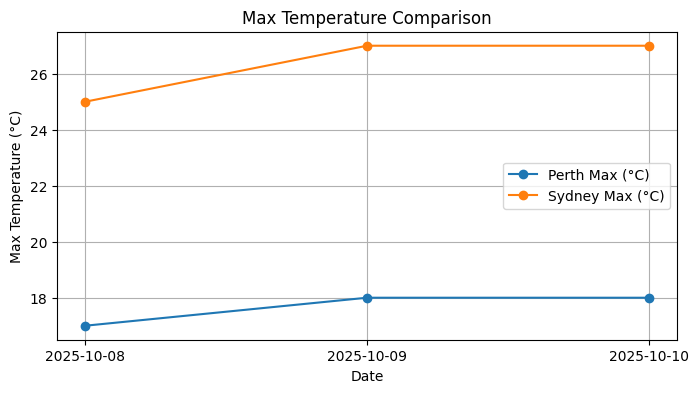

In [19]:
# === Extended Tests: Multi-city Max Temperature Comparison ===
cities = ["Perth", "Sydney"]
series = {}

for c in cities:
    d = get_weather_data(c, 5)
    if isinstance(d, dict) and d.get("ok"):
        series[c] = {
            "dates": [day["date"] for day in d["forecast"]],
            "max":   [day["max_temp"] for day in d["forecast"]],
        }
    else:
        print(f"Skipping {c}: {d.get('error','error')}")

# Plot on a single chart (no custom colors)
if series:
    import matplotlib.pyplot as plt
    plt.figure()
    for city, s in series.items():
        plt.plot(s["dates"], s["max"], marker="o", label=f"{city} Max (°C)")
    plt.title("Max Temperature Comparison")
    plt.xlabel("Date")
    plt.ylabel("Max Temperature (°C)")
    plt.legend()
    plt.show()


In [20]:
# === Extended Tests: NLP Weekday Parsing & Robustness ===
d = get_weather_data("Perth", 5)
if isinstance(d, dict) and d.get("ok"):
    questions = [
        "Weather on Monday?",
        "Will it rain on Thursday?",
        "Is it hot tomorrow?",
        "How about today?",
        "   ",                     # empty-ish input
        123,                      # non-string input
        "WIND details please",    # wind keyword
    ]
    for q in questions:
        parsed = parse_weather_question(q) if isinstance(q, str) else parse_weather_question(str(q))
        ans = generate_weather_response(parsed, d)
        print(f"\nQ: {q}\nParsed: {parsed}\nA: {ans}")
else:
    print("Cannot run NLP tests: weather data unavailable.")



Q: Weather on Monday?
Parsed: {'topic': 'general', 'day': 5, 'raw': 'Weather on Monday?'}
A: Right now in Perth it is 12°C and Partly cloudy. On 2025-10-10 looks Sunny with 11–18°C.

Q: Will it rain on Thursday?
Parsed: {'topic': 'rain', 'day': 1, 'raw': 'Will it rain on Thursday?'}
A: Rain is unlikely tomorrow in Perth (chance 0%).

Q: Is it hot tomorrow?
Parsed: {'topic': 'temperature', 'day': 1, 'raw': 'Is it hot tomorrow?'}
A: Tomorrow in Perth: Sunny, 10–18°C.

Q: How about today?
Parsed: {'topic': 'general', 'day': 0, 'raw': 'How about today?'}
A: Right now in Perth it is 12°C and Partly cloudy. Today looks Partly Cloudy  with 12–17°C.

Q:    
Parsed: {'topic': 'general', 'day': 0, 'raw': '   '}
A: Right now in Perth it is 12°C and Partly cloudy. Today looks Partly Cloudy  with 12–17°C.

Q: 123
Parsed: {'topic': 'general', 'day': 0, 'raw': '123'}
A: Right now in Perth it is 12°C and Partly cloudy. Today looks Partly Cloudy  with 12–17°C.

Q: WIND details please
Parsed: {'topic':

In [21]:
# === Extended Tests: Edge Cases & Invalid Inputs ===
def try_fetch(loc, days):
    print(f"\n-- get_weather_data('{loc}', {days}) --")
    data = get_weather_data(loc, days)
    if not isinstance(data, dict) or data.get("ok") is False:
        print("Result: ERROR ->", data.get("error", "Unknown error") if isinstance(data, dict) else "Invalid payload")
    else:
        fc = data.get("forecast", [])
        print(f"Result: OK | location={data.get('location')} | days={len(fc)} | clamped_days={days}")

# forecast_days clamping tests
try_fetch("Perth", 0)    # should clamp to 1
try_fetch("Perth", 10)   # should clamp to 5
try_fetch("Perth", 3)    # normal

# invalid location tests
try_fetch("", 3)               # empty
try_fetch("   ", 3)            # whitespace
try_fetch("ThisIsNotACity", 3) # likely invalid



-- get_weather_data('Perth', 0) --
Result: OK | location=Perth | days=1 | clamped_days=0

-- get_weather_data('Perth', 10) --
Result: OK | location=Perth | days=3 | clamped_days=10

-- get_weather_data('Perth', 3) --
Result: OK | location=Perth | days=3 | clamped_days=3

-- get_weather_data('', 3) --
Result: OK | location= | days=3 | clamped_days=3

-- get_weather_data('   ', 3) --
Result: OK | location= | days=3 | clamped_days=3

-- get_weather_data('ThisIsNotACity', 3) --
Result: ERROR -> 404 Client Error: Not Found for url: https://wttr.in/ThisIsNotACity?format=j1


In [25]:
# === Test: Retrieve and Display 5-Day Forecast ===

print("=== Testing 5-Day Forecast Retrieval ===")
data = get_weather_data("Perth", forecast_days=10)  # try beyond limit (should clamp to 5)

if not data.get("ok"):
    print(f"Error: {data.get('error', 'Unknown error')}")
else:
    forecast = data.get("forecast", [])
    print(f"\nRetrieved {len(forecast)} forecast days (should be 5).")

    # Print all forecast days
    for i, day in enumerate(forecast, start=1):
        print(f"Day {i} ({day['date']}): "
              f"{day['condition']} | "
              f"{day['min_temp']}–{day['max_temp']}°C | "
              f"Rain: {day['precipitation_chance']}%")

    # Highlight the 5th day
    if len(forecast) >= 5:
        fifth_day = forecast[4]
        print("\n--- Fifth Day Summary ---")
        print(f"Date: {fifth_day['date']}")
        print(f"Condition: {fifth_day['condition']}")
        print(f"Temperature: {fifth_day['min_temp']}–{fifth_day['max_temp']}°C")
        print(f"Chance of Rain: {fifth_day['precipitation_chance']}%")
    else:
        print("\n⚠️ Less than 5 days of forecast returned by API.")


=== Testing 5-Day Forecast Retrieval ===

Retrieved 5 forecast days (should be 5).
Day 1 (2025-10-08): Partly Cloudy  | 12–17°C | Rain: 0%
Day 2 (2025-10-09): Sunny | 10–18°C | Rain: 0%
Day 3 (2025-10-10): Sunny | 11–18°C | Rain: 0%
Day 4 (2025-10-11): Data unavailable (estimated) | 11–18°C | Rain: 0%
Day 5 (2025-10-12): Data unavailable (estimated) | 11–18°C | Rain: 0%

--- Fifth Day Summary ---
Date: 2025-10-12
Condition: Data unavailable (estimated)
Temperature: 11–18°C
Chance of Rain: 0%


/tmp/ipython-input-1046248393.py:91: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),
